In [36]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"2. STAN-Without Missing Data"
! pip install epiweeks
! pip install haversine
! pip install dgl

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/2. STAN-Without Missing Data


In [37]:
"""
Import libraries needed
"""
from data_downloader import GenerateTrainingData
from utils import gravity_law_commute_dist
import pickle
import pandas as pd
import dgl
import numpy as np

In [38]:
"""
Declare global variables used to preprocess data
"""
START_DATE = '2020-04-12'
END_DATE = '2022-01-24'
valid_window = 25
test_window = 25
history_window=6
pred_window=15
slide_step=5

In [39]:
"""
Download JHU data and merge it with population data
"""
# Download data
GenerateTrainingData().download_jhu_data(START_DATE, END_DATE)

#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
pop_data = pd.read_csv('./uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')


Finish download


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [40]:
"""
Create graph in DGL library based on similarities between locations 
"""
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}
for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

#Generate Graph
dist_threshold = 18
for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break
rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

g = dgl.graph((rows, cols))

In [41]:
"""
Preprocess data by separating it into different groups
"""
# Preprocess features
confirmed_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
static_feat = np.array(static_feat)[:, 0, :]


# Calculate change in # cases and # deaths from previous day
daily_change_in_confirmed = np.concatenate((np.zeros((confirmed_cases.shape[0], 1), dtype=np.float32), np.diff(confirmed_cases)), axis=-1)
daily_change_in_deaths = np.concatenate((np.zeros((death_cases.shape[0], 1), dtype=np.float32), np.diff(death_cases)), axis=-1)

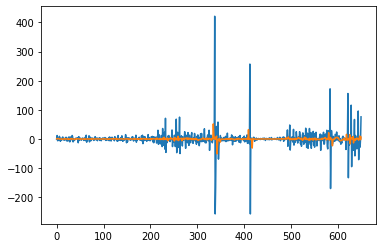

In [42]:
"""
Show/Plot the effect of smoothing the data 
"""
import matplotlib.pyplot as plt
# confirmed_cases.shape # (52, 650)
# death_cases.shape # (52, 650)
# daily_change_in_confirmed.shape # (52, 650)
# daily_change_in_deaths.shape # (52, 650)
# loc_list.index('Kentucky') # 17

# Define smoothing function from: https://www.delftstack.com/howto/python/smooth-data-in-python/
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Show raw data before smoothing
# y_raw = confirmed_cases[17]
# y_raw = death_cases[17]
# y_raw = daily_change_in_confirmed[17]
y_raw = daily_change_in_deaths[17]
plt.plot(np.arange(650), y_raw)

# Show data after smoothing (Show effect of smoothing)
y_smoothed = smooth(y_raw, 8)
plt.plot(np.arange(650), y_smoothed)


In [43]:
"""
Smooth the data
"""
for i in range(confirmed_cases.shape[0]):
  confirmed_cases[i] = smooth(confirmed_cases[i], 8)
  death_cases[i] = smooth(death_cases[i], 8)
  daily_change_in_confirmed[i] = smooth(daily_change_in_confirmed[i], 8)
  daily_change_in_deaths[i] = smooth(daily_change_in_deaths[i], 8)

In [44]:
"""
Put data together into 1 big numpy array
"""
dynamic_feat = np.concatenate((np.expand_dims(confirmed_cases, axis=-1),
                               np.expand_dims(death_cases, axis=-1),
                               np.expand_dims(daily_change_in_confirmed, axis=-1), 
                               np.expand_dims(daily_change_in_deaths, axis=-1)
                               ), axis=-1)

In [45]:
"""
Separate data into training, testing, and validation sets
"""

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

# Helper function for creating each set of data used
def prepare_data(data):
  # Data shape n_loc, timestep, n_feat
  # Reshape to n_loc, t, history_window*n_feat
  n_loc = data.shape[0]
  timestep = data.shape[1]
  n_feat = data.shape[2]

  x = []
  y_confirmed = []
  y_deaths = []

  for i in range(0, timestep, slide_step):
      if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
          break
      x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
      y_confirmed.append(data[:, i+history_window:i+history_window+pred_window, 0].reshape((n_loc, pred_window)))
      y_deaths.append(data[:, i+history_window:i+history_window+pred_window, 1].reshape((n_loc, pred_window)))

  # Change shape from (# timesteps, # states/locations, # features) to (# states/locations, # timesteps, # features)
  x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
  y_confirmed = np.array(y_confirmed, dtype=np.float32).transpose((1, 0, 2))
  y_deaths = np.array(y_deaths, dtype=np.float32).transpose((1, 0, 2))
  
  return x, y_confirmed, y_deaths

train_x, train_y_confirmed, train_y_deaths = prepare_data(train_feat)
val_x, val_y_confirmed, val_y_deaths = prepare_data(val_feat)
test_x, test_y_confirmed, test_y_deaths = prepare_data(test_feat)

In [46]:
"""
Package/organize preprocessed data together into a dictionary called "preprocessed_data"
"""
training_variables = {'train_x':train_x, 
                      'train_y_confirmed':train_y_confirmed,
                      'train_y_deaths':train_y_deaths}

validation_variables = {'val_x':val_x, 
                        'val_y_confirmed':val_y_confirmed,
                        'val_y_deaths':val_y_deaths}

testing_variables = {'test_x':test_x, 
                     'test_y_confirmed':test_y_confirmed,
                     'test_y_deaths':test_y_deaths}

preprocessed_data = {
    'training_variables':training_variables,
    'validation_variables':validation_variables,
    'testing_variables':testing_variables,
    'static_feat':static_feat,
    'loc_list':loc_list,
    'graph':g
}

In [48]:
"""
Put above code into 1 file and 1 function
"""
%%writefile preprocess_data_library3.py
"""
Import libraries needed
"""
from data_downloader import GenerateTrainingData
from utils import gravity_law_commute_dist
import pickle
import pandas as pd
import dgl
import numpy as np
##############################################################################################################################################
"""
Declare global variables used to preprocess data
"""
START_DATE = '2020-04-12'
END_DATE = '2022-01-24'
valid_window = 25
test_window = 25
history_window=6
pred_window=15
slide_step=5
##############################################################################################################################################

def get_preprocessed_data():
    """
    Download JHU data and merge it with population data
    """
    # Download data
    GenerateTrainingData().download_jhu_data(START_DATE, END_DATE)

    #Merge population data with downloaded data
    raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
    pop_data = pd.read_csv('./uszips.csv')
    pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
    raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')
    ##############################################################################################################################################
    """
    Create graph in DGL library based on similarities between locations 
    """
    # Generate location similarity
    loc_list = list(raw_data['state'].unique())
    loc_dist_map = {}
    for each_loc in loc_list:
        loc_dist_map[each_loc] = {}
        for each_loc2 in loc_list:
            lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
            lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
            pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
            
            lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
            lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
            pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
            
            loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

    #Generate Graph
    dist_threshold = 18
    for each_loc in loc_dist_map:
        loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    adj_map = {}
    for each_loc in loc_dist_map:
        adj_map[each_loc] = []
        for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
            if loc_dist_map[each_loc][each_loc2] > dist_threshold:
                if i <= 3:
                    adj_map[each_loc].append(each_loc2)
                else:
                    break
            else:
                if i <= 1:
                    adj_map[each_loc].append(each_loc2)
                else:
                    break
    rows = []
    cols = []
    for each_loc in adj_map:
        for each_loc2 in adj_map[each_loc]:
            rows.append(loc_list.index(each_loc))
            cols.append(loc_list.index(each_loc2))

    g = dgl.graph((rows, cols))
    ##############################################################################################################################################
    """
    Preprocess data by separating it into different groups
    """
    # Preprocess features
    confirmed_cases = []
    death_cases = []
    static_feat = []

    for i, each_loc in enumerate(loc_list):
        confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
        death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
        static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
        
    confirmed_cases = np.array(confirmed_cases)
    death_cases = np.array(death_cases)
    static_feat = np.array(static_feat)[:, 0, :]


    # Calculate change in # cases and # deaths from previous day
    daily_change_in_confirmed = np.concatenate((np.zeros((confirmed_cases.shape[0], 1), dtype=np.float32), np.diff(confirmed_cases)), axis=-1)
    daily_change_in_deaths = np.concatenate((np.zeros((death_cases.shape[0], 1), dtype=np.float32), np.diff(death_cases)), axis=-1)
    ##############################################################################################################################################
    """
    Smooth the data
    """
    # Define smoothing function from: https://www.delftstack.com/howto/python/smooth-data-in-python/
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    # Smooth data
    for i in range(confirmed_cases.shape[0]):
      confirmed_cases[i] = smooth(confirmed_cases[i], 8)
      death_cases[i] = smooth(death_cases[i], 8)
      daily_change_in_confirmed[i] = smooth(daily_change_in_confirmed[i], 8)
      daily_change_in_deaths[i] = smooth(daily_change_in_deaths[i], 8)
    ##############################################################################################################################################
    """
    Put data together into 1 big numpy array
    """
    dynamic_feat = np.concatenate((np.expand_dims(confirmed_cases, axis=-1),
                                  np.expand_dims(death_cases, axis=-1),
                                  np.expand_dims(daily_change_in_confirmed, axis=-1), 
                                  np.expand_dims(daily_change_in_deaths, axis=-1)
                                  ), axis=-1)

    ##############################################################################################################################################
    """
    Separate data into training, testing, and validation sets
    """

    #Split train-test
    train_feat = dynamic_feat[:, :-valid_window-test_window, :]
    val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
    test_feat = dynamic_feat[:, -test_window:, :]

    # Helper function for creating each set of data used
    def prepare_data(data):
      # Data shape n_loc, timestep, n_feat
      # Reshape to n_loc, t, history_window*n_feat
      n_loc = data.shape[0]
      timestep = data.shape[1]
      n_feat = data.shape[2]

      x = []
      y_confirmed = []
      y_deaths = []

      for i in range(0, timestep, slide_step):
          if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
              break
          x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
          y_confirmed.append(data[:, i+history_window:i+history_window+pred_window, 0].reshape((n_loc, pred_window)))
          y_deaths.append(data[:, i+history_window:i+history_window+pred_window, 1].reshape((n_loc, pred_window)))

      # Change shape from (# timesteps, # states/locations, # features) to (# states/locations, # timesteps, # features)
      x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
      y_confirmed = np.array(y_confirmed, dtype=np.float32).transpose((1, 0, 2))
      y_deaths = np.array(y_deaths, dtype=np.float32).transpose((1, 0, 2))
      
      return x, y_confirmed, y_deaths

    train_x, train_y_confirmed, train_y_deaths = prepare_data(train_feat)
    val_x, val_y_confirmed, val_y_deaths = prepare_data(val_feat)
    test_x, test_y_confirmed, test_y_deaths = prepare_data(test_feat)
    ##############################################################################################################################################
    """
    Package/organize preprocessed data together into a dictionary called "preprocessed_data"
    """
    training_variables = {'train_x':train_x, 
                          'train_y_confirmed':train_y_confirmed,
                          'train_y_deaths':train_y_deaths}

    validation_variables = {'val_x':val_x, 
                            'val_y_confirmed':val_y_confirmed,
                            'val_y_deaths':val_y_deaths}

    testing_variables = {'test_x':test_x, 
                        'test_y_confirmed':test_y_confirmed,
                        'test_y_deaths':test_y_deaths}

    preprocessed_data = {
        'training_variables':training_variables,
        'validation_variables':validation_variables,
        'testing_variables':testing_variables,
        'static_feat':static_feat,
        'loc_list':loc_list,
        'graph':g
    }

    return preprocessed_data

Writing preprocess_data_library3.py
